# Text Classification on Noisy IMDB Dataset using Naive Bayes

## 1. Experiment Details
|Specification|Value|
|----|----|
|AutoML Framework|NA - Naive Bayes|
|Task|Binary Text Classification|
|Dataset|IMDB Movie Reviews|
|Dataset Clean|No|
|Noise Type|Random|

## 2. Load Packages

In [1]:
# Packages for data processing
import numpy as np
import pandas as pd
from scripts.add_noise import add_gaussian_noise, add_random_noise
from scripts.data_preprocess import preprocess_text
from sklearn.model_selection import train_test_split

# Packages for AutoML framework execution
# from tpot.export_utils import set_param_recursive
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Packages for evaluation plots
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from scripts.plot_model_scores import get_plot_model

random_state = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yogesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yogesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 3. Load and Pre-process Dataset

In [2]:
# Get the required dataset from the datasets folder
imdb_df = pd.read_csv("../datasets/clean/imdb.csv", index_col=0)

In [3]:
# Sample the data for experimentation purposes
# Some AutoML frameworks can take long time to test multiple pipelines on large-scale data (e.g. 4+ hours on 50K+ text data)
imdb_df = imdb_df.sample(frac=0.2, replace=False, random_state=random_state)

In [4]:
# Certain AutoML frameworks such as TPOT require the target variable to be explicitly named as 'target'
imdb_df.reset_index(inplace=True)
imdb_df.rename(columns={'sentiment':'target'}, inplace=True)
imdb_df['target'] = imdb_df['target'].apply(lambda x: 1 if x =='positive' else 0)

In [5]:
# Pre-process the text to lower case, remove stopwords, lemmatize, etc.
imdb_df['tokenized_review'] = imdb_df['review'].apply(preprocess_text)

In [6]:
# Create a Word2Vec model and obtain embeddings for all the reviews in the dataset
from gensim.models import Word2Vec

sentences = imdb_df['tokenized_review'].tolist()
w2v_model_path = "word2vec_imdb"
w2v_model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, sg=0)
w2v_model.save(f"{w2v_model_path}.model")

In [7]:
if w2v_model is None: w2v_model = Word2Vec.load(f'{w2v_model_path}.model')

def get_w2v_average_embedding(tokens):
  # Calculate average word embedding for the tokens in a row
  vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
  if vectors: 
    return sum(vectors) / len(vectors)
  else:
    return None
  
imdb_df['review_embeddings'] = imdb_df['tokenized_review'].apply(get_w2v_average_embedding)

In [8]:
imdb_df.head()

,review,target,tokenized_review,review_embeddings
0,I really liked this Summerslam due to the look...,1,"[really, liked, summerslam, due, look, arena, ...","[0.0764632, 0.09245178, 0.29827252, 0.18685926..."
1,Not many television shows appeal to quite as m...,1,"[many, television, show, appeal, quite, many, ...","[0.15187353, 0.27983874, 0.38705465, 0.4304302..."
2,The film quickly gets to a major chase scene w...,0,"[film, quickly, get, major, chase, scene, ever...","[-0.035950527, 0.36396098, 0.33217156, 0.47295..."
3,Jane Austen would definitely approve of this o...,1,"[jane, austen, would, definitely, approve, one...","[0.17579365, 0.31197482, 0.5382422, 0.4079419,..."
4,Expectations were somewhat high for me when I ...,0,"[expectation, somewhat, high, went, see, movie...","[0.07337436, 0.25124803, 0.35479334, 0.4511706..."


## 4. Train Model and Predict

In [9]:
# Split the dataset into traning and testing splits
X_train, X_test, y_train, y_test = train_test_split(np.vstack(imdb_df['review_embeddings']),
                                                    imdb_df.loc[:, 'target'], 
                                                    train_size=0.75, test_size=0.25, random_state=random_state)

In [10]:
# We run Naive Bayes model to define a benchmark for F1-score, precision, and recall
naive_bayes_model = make_pipeline(
    Normalizer(norm="l2"),
    BernoulliNB(alpha=1.0, fit_prior=True)
)

naive_bayes_model.fit(X_train, y_train)
y_pred_naive_bayes = naive_bayes_model.predict(X_test)

## 5. Evaluate Model

In [11]:
# We now evaluate our model performances on this dataset and compare against the Naive Bayes benchmark
precision_naive_bayes = precision_score(y_true=y_test, y_pred=y_pred_naive_bayes)
recall_naive_bayes = recall_score(y_true=y_test, y_pred=y_pred_naive_bayes)
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes)

model_names = ['Naive Bayes']
plot_title = 'Clean Data - Naive Bayes Performance'
f1_scores = [f1_naive_bayes]
recall_scores = [recall_naive_bayes]
precision_scores = [precision_naive_bayes]

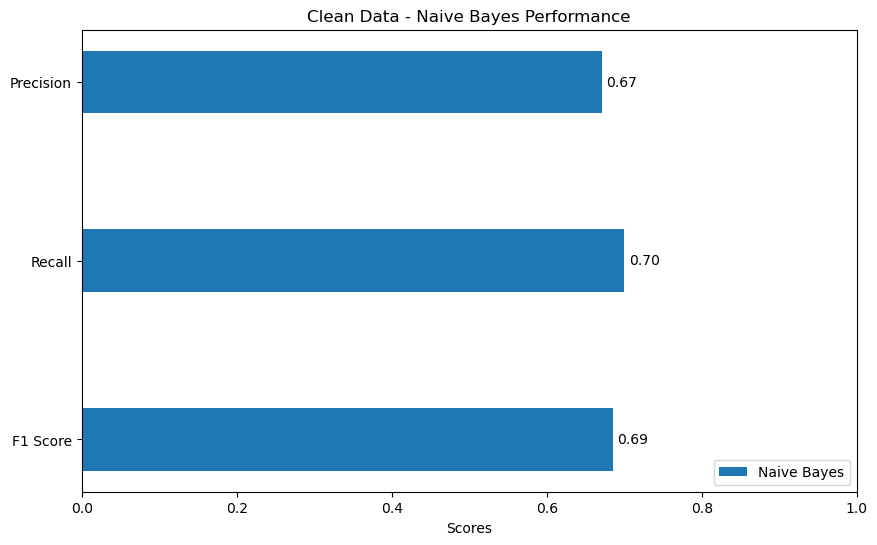

In [12]:
from scripts.plot_model_scores import get_plot_model
fig = get_plot_model(model_names=model_names, f1_scores=f1_scores, recall_scores=recall_scores, precision_scores=precision_scores, title=plot_title)
plt.show()